In [1]:
# Core libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Preprocessing
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import RobustScaler

# Models
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB
import joblib

# Metrics and evaluation
from sklearn.metrics import (
    accuracy_score, 
    precision_score, 
    recall_score, 
    f1_score,
    confusion_matrix, 
    ConfusionMatrixDisplay,
    roc_curve, 
    roc_auc_score
)

# Basic Data Cleaning

In [2]:
df = pd.read_csv("Group7.csv")
df.head()

,id,Gender,Age,City,Profession,Academic Pressure,Work Pressure,CGPA,Study Satisfaction,Job Satisfaction,Sleep Duration,Dietary Habits,Degree,Have you ever had suicidal thoughts ?,Work/Study Hours,Financial Stress,Family History of Mental Illness,Depression
0,2,Male,33,Visakhapatnam,Student,5,0,8.97,2,0,'5-6 hours',Healthy,B.Pharm,Yes,3,1,No,1
1,8,Female,24,Bangalore,Student,2,0,5.90,5,0,'5-6 hours',Moderate,BSc,No,3,2,Yes,0
2,26,Male,31,Srinagar,Student,3,0,7.03,5,0,'Less than 5 hours',Healthy,BA,No,9,1,Yes,0
3,30,Female,28,Varanasi,Student,3,0,5.59,2,0,'7-8 hours',Moderate,BCA,Yes,4,5,Yes,1
4,32,Female,25,Jaipur,Student,4,0,8.13,3,0,'5-6 hours',Moderate,M.Tech,Yes,1,1,No,0


In [3]:
df['Profession'].value_counts()

Profession
Student                     27870
Architect                       8
Teacher                         6
'Digital Marketer'              3
'Content Writer'                2
Chef                            2
Doctor                          2
Pharmacist                      2
'Civil Engineer'                1
'UX/UI Designer'                1
'Educational Consultant'        1
Manager                         1
Lawyer                          1
Entrepreneur                    1
Name: count, dtype: int64

As our target demographic is Students, we will be filtering other professions.

In [4]:
df= df[df['Profession'] == 'Student']
df['Profession'].value_counts()

Profession
Student    27870
Name: count, dtype: int64

Renaming for conciseness

In [5]:
df.rename(columns={"Have you ever had suicidal thoughts ?": "Suicidal Thoughts"}, inplace=True)

In [6]:
df.rename(columns={"Family History of Mental Illness": "Family History"}, inplace=True)

In [7]:
df.rename(columns={"Work/Study Hours": "Work Hours"}, inplace=True)

In [8]:
df['Work Pressure'].value_counts()

Work Pressure
0    27867
5        2
2        1
Name: count, dtype: int64

1. These are unemployed students
2. Only 3 have reported higher work pressure

So we will be removing them.

In [9]:
df= df[df['Work Pressure'] == 0]
df['Work Pressure'].value_counts()

Work Pressure
0    27867
Name: count, dtype: int64

In [10]:
df['Job Satisfaction'].value_counts()

Job Satisfaction
0    27862
2        3
3        1
1        1
Name: count, dtype: int64

1. Unemployed Students cannot have a Job Satisfaction score
2. Only 5 students reported.

So removing these outliers as well.

In [11]:
df= df[df['Job Satisfaction'] == 0]
df['Job Satisfaction'].value_counts()

Job Satisfaction
0    27862
Name: count, dtype: int64

In [12]:
df.drop(columns=["City", "id", "Profession", "Work Pressure", "Job Satisfaction", "Degree"], inplace=True)

Dropping the columns that are unimportant to our goals. I will also drop the Degree Features as these degrees are not offered by our university and therefore irrelevant for our application which is a an Early Depression Tool that will be used by UITU counsellors.

In [13]:
df['Sleep Duration'].value_counts()

Sleep Duration
'Less than 5 hours'    8300
'7-8 hours'            7334
'5-6 hours'            6176
'More than 8 hours'    6034
Others                   18
Name: count, dtype: int64

removes rows where the Sleep Duration is 'Others' because It’s likely an invalid category or input error
1. Only 18 students reported.
2. We cannot encode this column into ordinal enconding with 'Others'

In [14]:
df= df[df['Sleep Duration'] != 'Others' ]
df['Sleep Duration'].value_counts()

Sleep Duration
'Less than 5 hours'    8300
'7-8 hours'            7334
'5-6 hours'            6176
'More than 8 hours'    6034
Name: count, dtype: int64

In [15]:
df['Dietary Habits'].value_counts()

Dietary Habits
Unhealthy    10299
Moderate      9898
Healthy       7635
Others          12
Name: count, dtype: int64

Removing 'Others' from Dietary Habit as well. Now we can easily do Ordinal Encoding on it.

In [16]:
df= df[df['Dietary Habits'] != 'Others' ]
df['Dietary Habits'].value_counts()

Dietary Habits
Unhealthy    10299
Moderate      9898
Healthy       7635
Name: count, dtype: int64

same as above

In [17]:
# unique values for each column

print("Suicidal Thoughts:", df["Suicidal Thoughts"].unique())
print("Dietary Habits:", df["Dietary Habits"].unique())
print("Family History:", df["Family History"].unique())
print("Gender:", df["Gender"].unique())
print("Sleep Duration:", df["Sleep Duration"].unique())

Suicidal Thoughts: ['Yes' 'No']
Dietary Habits: ['Healthy' 'Moderate' 'Unhealthy']
Family History: ['No' 'Yes']
Gender: ['Male' 'Female']
Sleep Duration: ["'5-6 hours'" "'Less than 5 hours'" "'7-8 hours'" "'More than 8 hours'"]


In [18]:
df["Sleep Duration"] = df["Sleep Duration"].str.replace("'", "") #Removing exta inverted commas

# Data Preprocessing

## Handling Missing Values:

In [19]:
# Summary of missing values in each column
missing_summary = df.isnull().sum()

# Filter columns with missing values
missing_columns = missing_summary[missing_summary > 0]

# Conditional message
if not missing_columns.empty:
    print("After checking, the following columns have missing values:\n")
    print(missing_columns)
else:
    print("No columns with missing values were found.")


No columns with missing values were found.


## Encoding Columns:

In [20]:
# Ordinal Encoding

sleep_map = {
    'Less than 5 hours': 1,
    '5-6 hours': 2,
    '7-8 hours': 3,
    'More than 8 hours': 4
}

# Apply the mapping
df['Sleep Duration'] = df['Sleep Duration'].replace(sleep_map)

joblib.dump(sleep_map, 'Mappings/sleep_map.pkl')

C:\Users\sahir\AppData\Local\Temp\ipykernel_19964\476185418.py:11: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['Sleep Duration'] = df['Sleep Duration'].replace(sleep_map)


['Mappings/sleep_map.pkl']

In [21]:
# Ordinal Encoding

diet_map = {
    'Unhealthy': 1,
    'Moderate': 2,
    'Healthy': 3
}

# Apply the mapping to the column
df['Dietary Habits'] = df['Dietary Habits'].replace(diet_map)

joblib.dump(diet_map, 'Mappings/diet_map.pkl')

C:\Users\sahir\AppData\Local\Temp\ipykernel_19964\3755909362.py:10: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['Dietary Habits'] = df['Dietary Habits'].replace(diet_map)


['Mappings/diet_map.pkl']

In [22]:
df.head()

,Gender,Age,Academic Pressure,CGPA,Study Satisfaction,Sleep Duration,Dietary Habits,Suicidal Thoughts,Work Hours,Financial Stress,Family History,Depression
0,Male,33,5,8.97,2,2,3,Yes,3,1,No,1
1,Female,24,2,5.90,5,2,2,No,3,2,Yes,0
2,Male,31,3,7.03,5,1,3,No,9,1,Yes,0
3,Female,28,3,5.59,2,3,2,Yes,4,5,Yes,1
4,Female,25,4,8.13,3,2,2,Yes,1,1,No,0


In [23]:
#Label encoding Yes/No Columns

label_encoders = {}
for col in ["Suicidal Thoughts", "Family History", "Gender"]:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col].astype(str))
    label_encoders[col] = le  # Save the encoder if you want to inverse transform later
    joblib.dump(le, f'LabelEncoders/le_{col}.pkl')  # Save encoder
df.head()

,Gender,Age,Academic Pressure,CGPA,Study Satisfaction,Sleep Duration,Dietary Habits,Suicidal Thoughts,Work Hours,Financial Stress,Family History,Depression
0,1,33,5,8.97,2,2,3,1,3,1,0,1
1,0,24,2,5.90,5,2,2,0,3,2,1,0
2,1,31,3,7.03,5,1,3,0,9,1,1,0
3,0,28,3,5.59,2,3,2,1,4,5,1,1
4,0,25,4,8.13,3,2,2,1,1,1,0,0


df = pd.get_dummies(df, columns=[cols], drop_first=True)
df.head()

One-hot encoding is not applicable to our dataset.

for col in df.columns:
    df[col] = df[col].astype(int)

#Throws an error because one of the col has a '?' in it. Finding the '?':

In [24]:
print(df.isin(['?']).sum())  # This will tell us if there are still '?' values in any columns

Gender                0
Age                   0
Academic Pressure     0
CGPA                  0
Study Satisfaction    0
Sleep Duration        0
Dietary Habits        0
Suicidal Thoughts     0
Work Hours            0
Financial Stress      3
Family History        0
Depression            0
dtype: int64


Financial Interest has 3 question marks probably due to missing values. Clearing it.

In [25]:
df['Financial Stress'] = df['Financial Stress'].replace('?', 0)

Now converting all columns to int for uniformity.

In [26]:
for col in df.columns:
    if col != 'CGPA':
        df[col] = df[col].astype(float).round().astype(int)

    
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 27832 entries, 0 to 27900
Data columns (total 12 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Gender              27832 non-null  int32  
 1   Age                 27832 non-null  int32  
 2   Academic Pressure   27832 non-null  int32  
 3   CGPA                27832 non-null  float64
 4   Study Satisfaction  27832 non-null  int32  
 5   Sleep Duration      27832 non-null  int32  
 6   Dietary Habits      27832 non-null  int32  
 7   Suicidal Thoughts   27832 non-null  int32  
 8   Work Hours          27832 non-null  int32  
 9   Financial Stress    27832 non-null  int32  
 10  Family History      27832 non-null  int32  
 11  Depression          27832 non-null  int32  
dtypes: float64(1), int32(11)
memory usage: 1.6 MB


In [27]:
df_encoded = df.copy() #will train on it as-is later

## Checking Data Distribution, Outliers Handling and Scaling

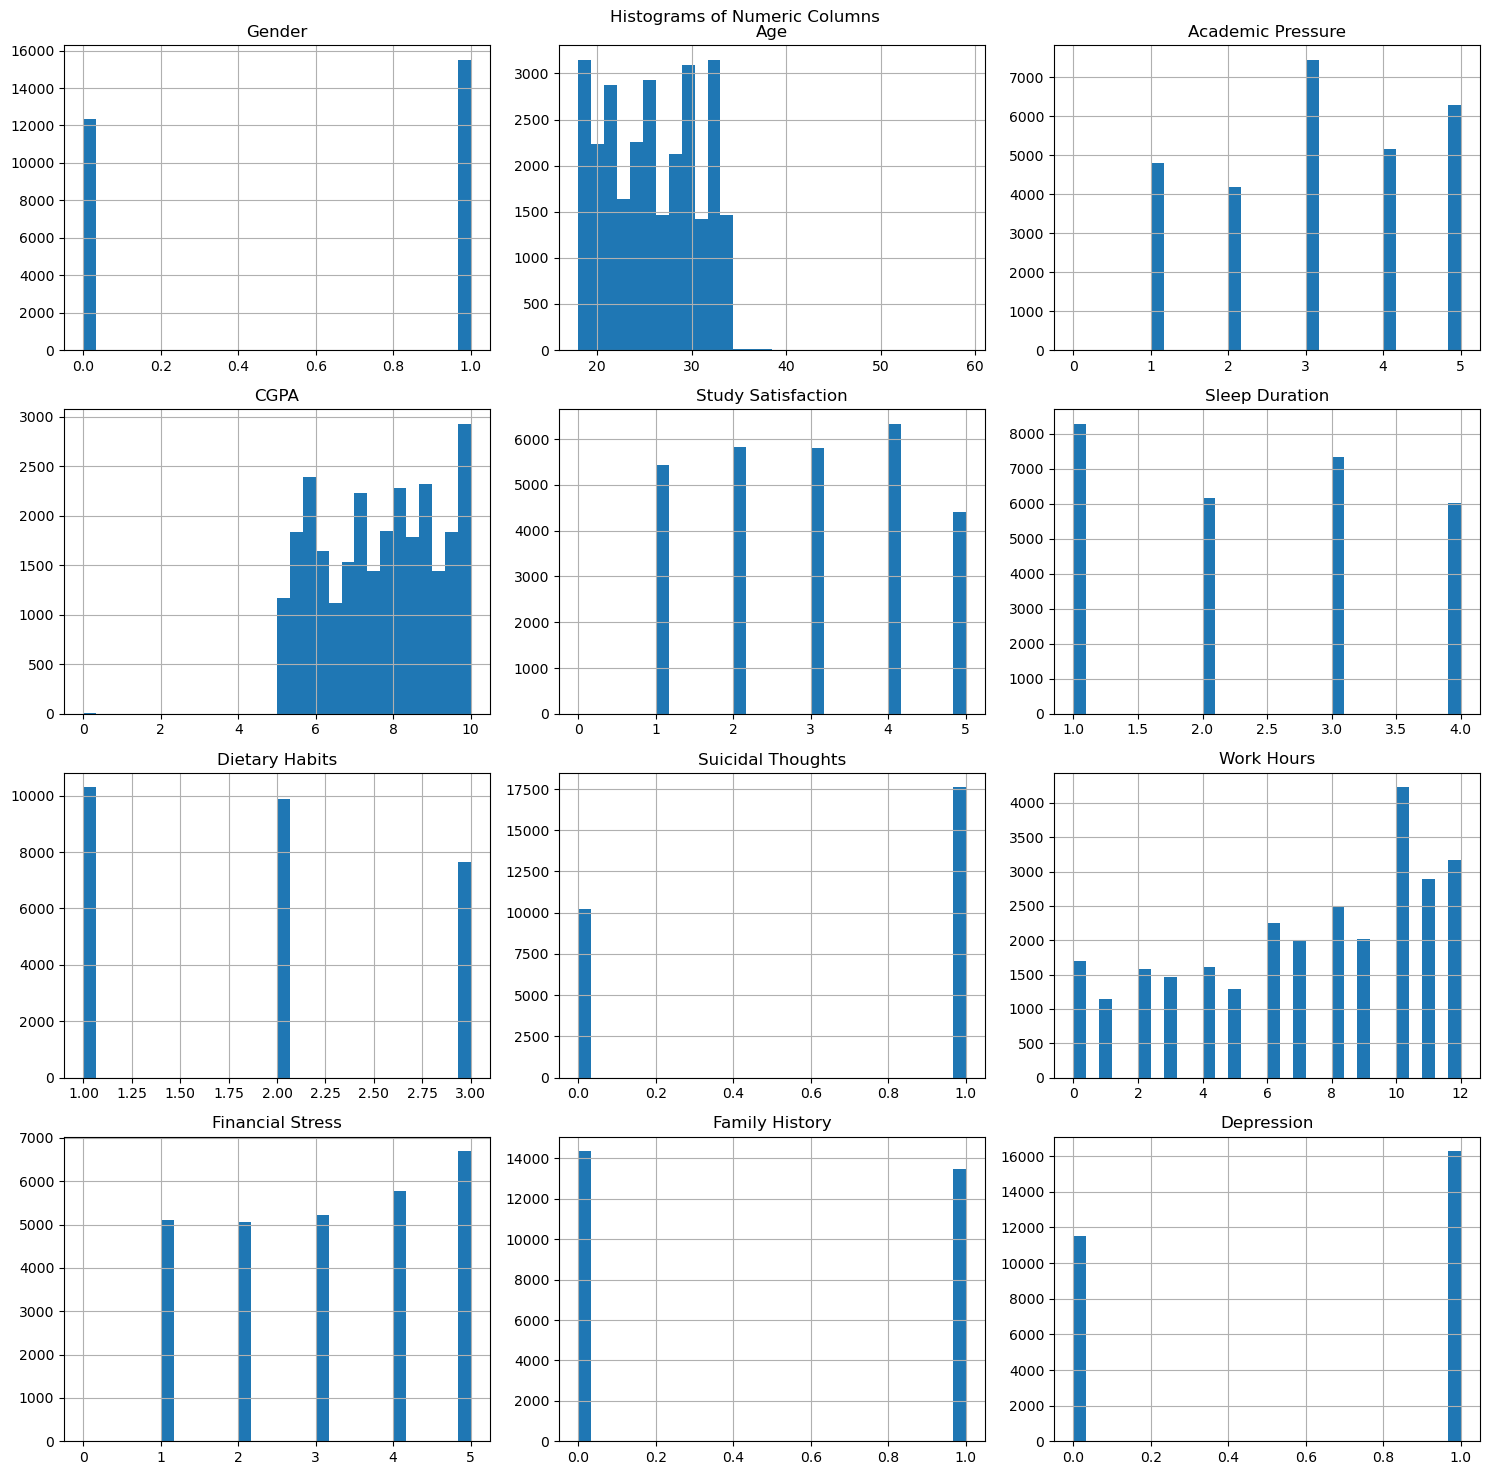

In [28]:
# Plot histograms for all numeric columns
df.hist(bins=30, figsize=(15, 15))  # Adjust the figure size
plt.suptitle("Histograms of Numeric Columns")

# Adjust layout to prevent overlapping
plt.tight_layout()

# Show the plot
plt.show()

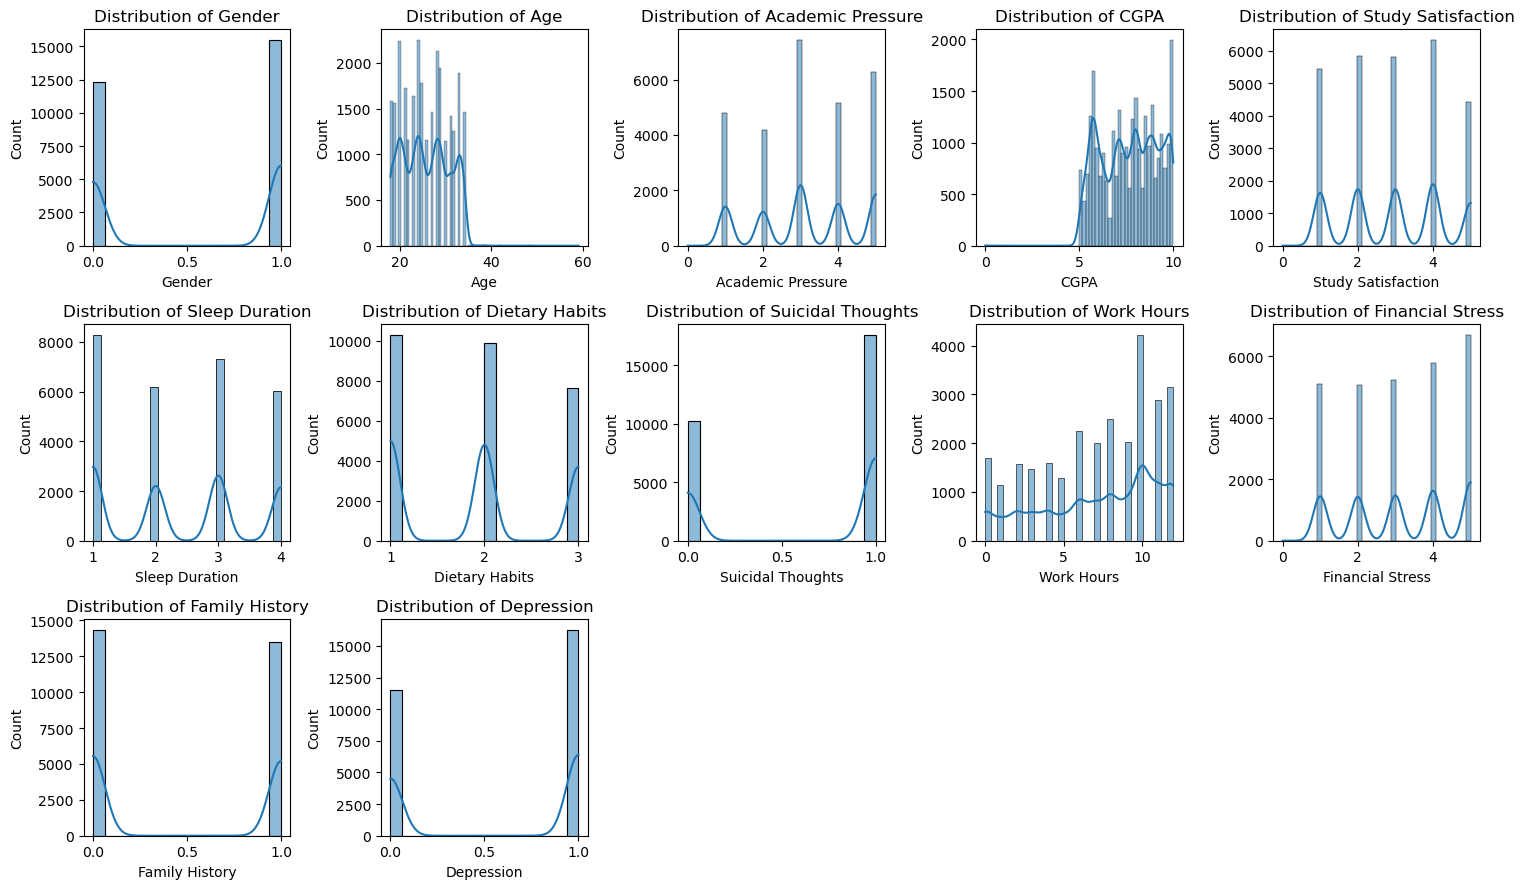

In [29]:
# Number of numeric columns
num_cols = len(df.select_dtypes(include=[np.number]).columns)

# Calculate rows and columns for the grid
ncols = 5  # You can change this based on the number of columns you want per row
nrows = int(np.ceil(num_cols / ncols))  # Ceiling to get enough rows

# Create subplots dynamically based on the number of columns
plt.figure(figsize=(ncols * 3, nrows * 3))  # Adjust the figure size

# Loop through the numeric columns and create a subplot for each
for i, col in enumerate(df.select_dtypes(include=[np.number]).columns):
    plt.subplot(nrows, ncols, i + 1)  # Adjust to grid
    sns.histplot(df[col], kde=True)  # Plot histogram with KDE
    plt.title(f"Distribution of {col}")

# Adjust the layout to make sure everything fits nicely
plt.tight_layout()

# Display the plot
plt.show()

### Outliers Handling

In [30]:
cols_for_outlier_handling = ['Age', 'CGPA', 'Work Hours'] #Selected cols for outlier handlng

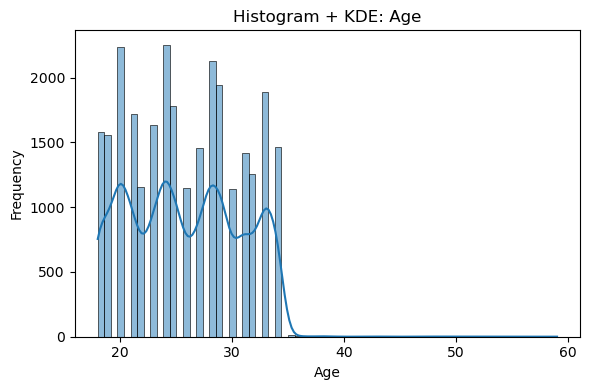

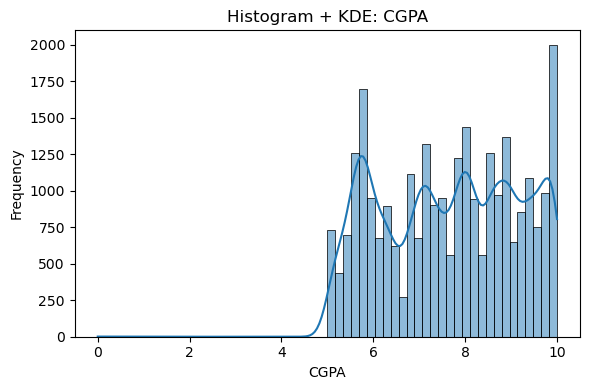

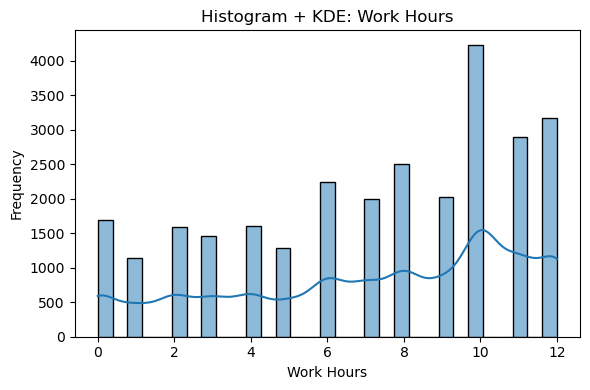

In [31]:
for col in cols_for_outlier_handling:
    plt.figure(figsize=(6, 4))
    sns.histplot(df[col].dropna(), kde=True)
    plt.title(f'Histogram + KDE: {col}')
    plt.xlabel(col)
    plt.ylabel('Frequency')
    plt.tight_layout()
    plt.show()

Since, these columns are not normally distributed we will use IQR instead of zscore

In [32]:
# Calculate IQR for each numeric column
Q1 = df.quantile(0.25)
Q3 = df.quantile(0.75)
IQR = Q3 - Q1

# Identify outliers
outliers_iqr = ((df < (Q1 - 1.5 * IQR)) | 
                (df > (Q3 + 1.5 * IQR)))

# Count outliers in each column
outliers_count_iqr = outliers_iqr.sum()

# Show outliers count for each column
outliers_count_iqr_df = pd.DataFrame(outliers_count_iqr, index=cols_for_outlier_handling, columns=["Outliers Count"])
print(outliers_count_iqr_df)


            Outliers Count
Age                     12
CGPA                     3
Work Hours               0


In [33]:
def remove_outliers_iqr(df, col):
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    return df[(df[col] >= lower) & (df[col] <= upper)]

for col in cols_for_outlier_handling:
    df = remove_outliers_iqr(df, col)


In [34]:
# Calculate IQR for each numeric column
Q1 = df.quantile(0.25)
Q3 = df.quantile(0.75)
IQR = Q3 - Q1

# Identify outliers
outliers_iqr = ((df < (Q1 - 1.5 * IQR)) | 
                (df > (Q3 + 1.5 * IQR)))

# Count outliers in each column
outliers_count_iqr = outliers_iqr.sum()

# Show outliers count for each column
outliers_count_iqr_df = pd.DataFrame(outliers_count_iqr, index=cols_for_outlier_handling, columns=["Outliers Count"])
print(outliers_count_iqr_df)


            Outliers Count
Age                      0
CGPA                     0
Work Hours               0


No outliers now.

In [35]:
df_encoded_outliersHandled = df.copy()

### Scaling

In [36]:
df.columns

Index(['Gender', 'Age', 'Academic Pressure', 'CGPA', 'Study Satisfaction',
       'Sleep Duration', 'Dietary Habits', 'Suicidal Thoughts', 'Work Hours',
       'Financial Stress', 'Family History', 'Depression'],
      dtype='object')

In [37]:
cols_for_scaling = ['Age', 'CGPA', 'Work Hours']

Since our columns are not normally distributed we will use RobustScaler instead of StandardScaler

In [38]:
numericScaler = RobustScaler()
df[cols_for_scaling] = numericScaler.fit_transform(df[cols_for_scaling])
joblib.dump(numericScaler, 'Scalers/numericScaler.pkl')

['Scalers/numericScaler.pkl']

We also need to scale our Ordinal Columns as some of them range from 0-5 and some from 1-3. Since we are using Logistic Regression, it's important that we scale these values.

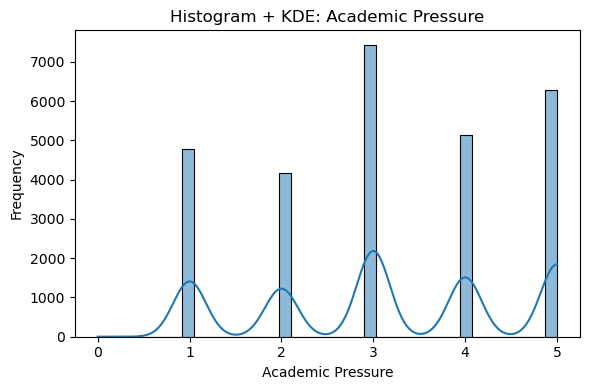

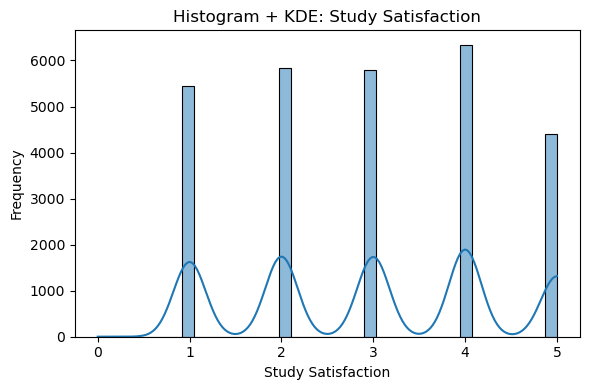

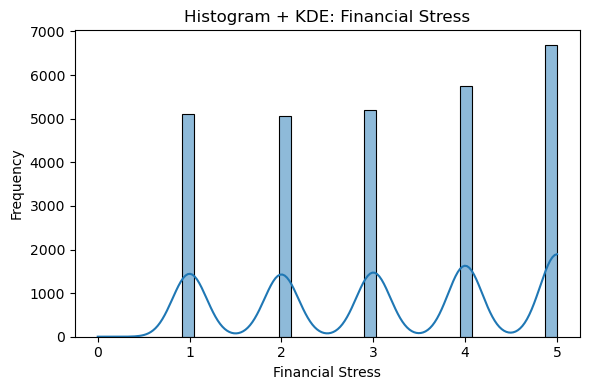

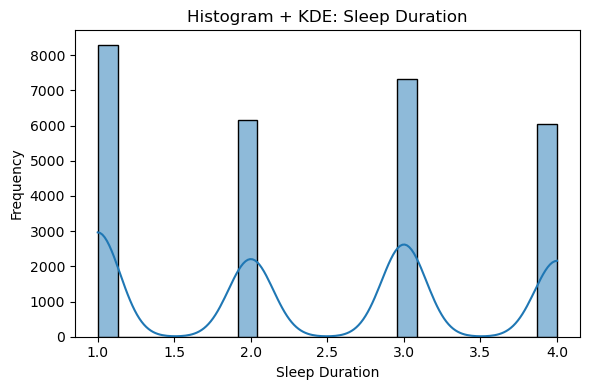

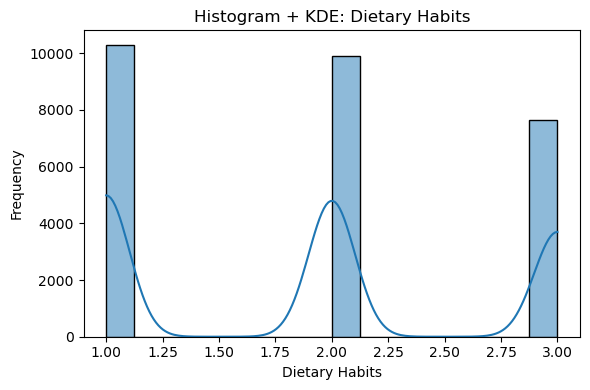

In [39]:
ordinalCols_forScaling = ['Academic Pressure', 'Study Satisfaction','Financial Stress', 'Sleep Duration', 'Dietary Habits']
for col in ordinalCols_forScaling:
    plt.figure(figsize=(6, 4))
    sns.histplot(df[col].dropna(), kde=True)
    plt.title(f'Histogram + KDE: {col}')
    plt.xlabel(col)
    plt.ylabel('Frequency')
    plt.tight_layout()
    plt.show()

These ordinal columns are also not normally distrubuted, so we will use RobustScaler on them.
We will scale Academic and Financial Stress and Study Satisfaction together as they are on a 0-5 scale.
We will scale Sleep Duration alone as it ranges from 1-4.
We will scale Dietary Habits alone as it ranges from 1-3.

In [40]:
# Create scalers
scaler_0_5 = RobustScaler()
scaler_1_4 = RobustScaler()
scaler_1_3 = RobustScaler()

# Scale columns separately
df[["Academic Pressure", "Financial Stress", "Study Satisfaction"]] = scaler_0_5.fit_transform(
    df[["Academic Pressure", "Financial Stress", "Study Satisfaction"]]
)

df[["Sleep Duration"]] = scaler_1_4.fit_transform(df[["Sleep Duration"]])

df[["Dietary Habits"]] = scaler_1_3.fit_transform(df[["Dietary Habits"]])

#save scalers
joblib.dump(scaler_0_5, 'Scalers/scaler_0_5.pkl')
joblib.dump(scaler_1_4, 'Scalers/scaler_1_4.pkl')
joblib.dump(scaler_1_3, 'Scalers/scaler_1_3.pkl')

['Scalers/scaler_1_3.pkl']

In [41]:
df_encoded_outliersHandled_standardized = df.copy()

Checking if each column has correct values:

In [42]:
for col in df.columns:
    print(f"{col}: {df[col].unique()}")

Gender: [1 0]
Age: [ 0.88888889 -0.11111111  0.66666667  0.33333333  0.          0.44444444
  0.55555556  0.22222222 -0.66666667 -0.55555556 -0.22222222 -0.77777778
 -0.44444444 -0.33333333  1.          0.77777778  0.11111111  1.55555556
  1.11111111  1.88888889  1.22222222  1.44444444  2.          1.33333333
  1.77777778]
Academic Pressure: [ 1.  -0.5  0.   0.5 -1.  -1.5]
CGPA: [ 0.45627376 -0.71102662 -0.28136882 -0.82889734  0.13688213 -0.78707224
  0.6730038   0.1026616   0.76806084  0.23193916 -0.63498099 -0.27756654
  0.2851711  -0.80988593  0.30798479 -0.47908745 -0.19771863  0.02281369
  0.82129278  0.36882129 -0.39543726 -0.8365019   0.31178707 -0.25475285
 -0.64258555 -0.77186312  0.79467681 -0.40684411 -0.59315589 -0.72243346
 -0.53231939  0.74144487 -0.71863118  0.68060837 -0.29657795 -0.96197719
  0.54752852  0.03041825 -0.31178707 -0.72623574  0.05703422  0.71863118
  0.44486692  0.73764259  0.03802281 -0.82509506  0.04942966 -0.878327
 -0.37262357  0.35361217 -0.14828897

Numerical cols: OK, outliers handled and standardized
Categorical cols: Encoded and cleaned.

# Feature Engineering:

In [43]:
df['Total_Stress'] = df['Academic Pressure'] + df['Financial Stress']

In [44]:
df['High_Mental_Risk'] = (
    (df['Suicidal Thoughts'] == 1).astype(int) + 
    (df['Family History'] == 1).astype(int) + 
    (df['Financial Stress'] > 2).astype(int)
) >= 2

In [45]:
df['High_Mental_Risk'] = df['High_Mental_Risk'].astype(int)

In [46]:
cols = [c for c in df.columns if c != 'Depression'] + ['Depression']  # moving target variable to the last
df = df[cols]

df.head()

,Gender,Age,Academic Pressure,CGPA,Study Satisfaction,Sleep Duration,Dietary Habits,Suicidal Thoughts,Work Hours,Financial Stress,Family History,Total_Stress,High_Mental_Risk,Depression
0,1,0.888889,1.0,0.456274,-0.5,0.0,0.5,1,-0.833333,-1.0,0,0.0,0,1
1,0,-0.111111,-0.5,-0.711027,1.0,0.0,0.0,0,-0.833333,-0.5,1,-1.0,0,0
2,1,0.666667,0.0,-0.281369,1.0,-0.5,0.5,0,0.166667,-1.0,1,-1.0,0,0
3,0,0.333333,0.0,-0.828897,-0.5,0.5,0.0,1,-0.666667,1.0,1,1.0,1,1
4,0,0.000000,0.5,0.136882,0.0,0.0,0.0,1,-1.166667,-1.0,0,-0.5,0,0


In [47]:
df_encoded_outliersHandled_featureEngineering = df.copy()

## Feature Selection:

In [48]:
from sklearn.decomposition import PCA
pca = PCA(n_components=10)
pca_components = pca.fit_transform(df.iloc[:, :-1])
pca_df = pd.DataFrame(pca_components, columns=[f"PCA_{i}" for i in range(1, 11)])
pca_df.head()

,PCA_1,PCA_2,PCA_3,PCA_4,PCA_5,PCA_6,PCA_7,PCA_8,PCA_9,PCA_10
0,-0.265622,-0.854169,-0.053111,1.423494,-0.436173,-0.488917,0.544035,0.506904,0.368590,0.517794
1,-1.579013,0.931091,0.512717,0.208571,-0.593365,-0.009454,-0.659671,-0.187652,-0.457352,-0.543478
2,-1.589649,0.364858,1.002947,0.503869,0.366272,-0.613149,-0.220639,0.627417,0.348522,-0.731228
3,1.149169,-0.045318,-0.134983,-0.744123,-0.947038,0.511811,-0.802978,0.388928,-0.392589,0.231016
4,-0.840845,-0.269501,0.128925,1.178551,-0.710926,-0.304870,0.138835,-0.443227,-0.476563,0.638143


In [49]:
# Access PCA component weights
loadings = pd.DataFrame(
    pca.components_,
    columns=df.columns[:-1],  # Exclude 'target'
    index=[f"PCA_{i}" for i in range(1, 11)]
)

# Show which features contribute most to each component
loadings = loadings.T.sort_values(by="PCA_1", ascending=False)
loadings.head()

,PCA_1,PCA_2,PCA_3,PCA_4,PCA_5,PCA_6,PCA_7,PCA_8,PCA_9,PCA_10
Total_Stress,0.798872,0.093065,-0.034317,0.094822,-0.022862,-0.004422,0.016222,0.053359,-0.003308,-0.076122
Financial Stress,0.415127,0.348032,-0.368934,-0.476245,0.001050,-0.039048,-0.080138,0.046277,-0.011215,-0.004781
Academic Pressure,0.383746,-0.254967,0.334616,0.571067,-0.023913,0.034626,0.096360,0.007082,0.007907,-0.071341
Suicidal Thoughts,0.134965,-0.152694,0.225234,-0.190982,-0.037232,-0.015027,0.016512,-0.139706,0.071430,0.804110
High_Mental_Risk,0.081579,-0.196646,0.415274,-0.396366,-0.260735,0.036060,0.015966,0.052300,0.021813,0.104933


In [50]:
df.shape

(27817, 14)

Total 13 Features
Let's select 10 from PCA and 10 from K-best then compare.

In [51]:
shortlisted_features_pca = loadings.index[:10]
shortlisted_features_pca

Index(['Total_Stress', 'Financial Stress', 'Academic Pressure',
       'Suicidal Thoughts', 'High_Mental_Risk', 'Work Hours', 'Family History',
       'CGPA', 'Gender', 'Sleep Duration'],
      dtype='object')

In [52]:
from sklearn.feature_selection import SelectKBest, f_classif

selector = SelectKBest(score_func=f_classif, k=10)
X_new = selector.fit_transform(df.iloc[:, :-1], df['Depression'])

selected_features = selector.get_support(indices=True)
selected_df = df.iloc[:, selected_features]
selected_df.head()

,Age,Academic Pressure,Study Satisfaction,Sleep Duration,Dietary Habits,Suicidal Thoughts,Work Hours,Financial Stress,Total_Stress,High_Mental_Risk
0,0.888889,1.0,-0.5,0.0,0.5,1,-0.833333,-1.0,0.0,0
1,-0.111111,-0.5,1.0,0.0,0.0,0,-0.833333,-0.5,-1.0,0
2,0.666667,0.0,1.0,-0.5,0.5,0,0.166667,-1.0,-1.0,0
3,0.333333,0.0,-0.5,0.5,0.0,1,-0.666667,1.0,1.0,1
4,0.000000,0.5,0.0,0.0,0.0,1,-1.166667,-1.0,-0.5,0


In [53]:
shortlisted_features_pca

Index(['Total_Stress', 'Financial Stress', 'Academic Pressure',
       'Suicidal Thoughts', 'High_Mental_Risk', 'Work Hours', 'Family History',
       'CGPA', 'Gender', 'Sleep Duration'],
      dtype='object')

In [54]:
shortlisted_features_kbest = selected_df.columns
shortlisted_features_kbest

Index(['Age', 'Academic Pressure', 'Study Satisfaction', 'Sleep Duration',
       'Dietary Habits', 'Suicidal Thoughts', 'Work Hours', 'Financial Stress',
       'Total_Stress', 'High_Mental_Risk'],
      dtype='object')

Top 10 Important Features:
 Suicidal Thoughts     0.194457
Total_Stress          0.160285
CGPA                  0.118297
Age                   0.103205
Work Hours            0.086418
Academic Pressure     0.084672
Study Satisfaction    0.053172
Financial Stress      0.051420
Sleep Duration        0.043384
Dietary Habits        0.038166
dtype: float64


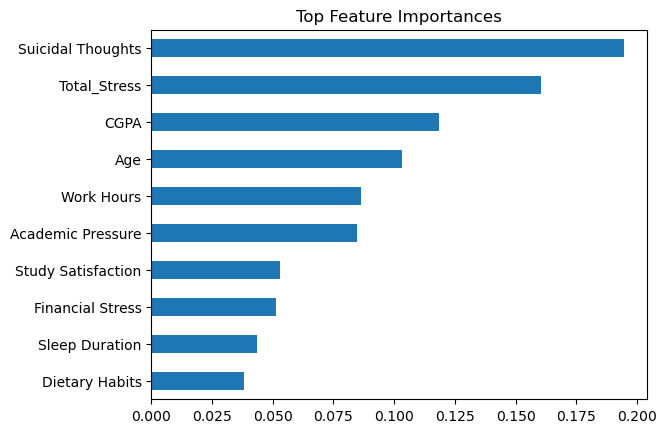

In [55]:
target = 'Depression'
X = df.drop(columns=[target])
y = df[target]

from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier()
model.fit(X, y)

# Get feature importances
importances = pd.Series(model.feature_importances_, index=X.columns)
shortlisted_features_RF = importances.sort_values(ascending=False).head(10)
print("Top 10 Important Features:\n", shortlisted_features_RF)

# Plot
shortlisted_features_RF.plot(kind='barh')
plt.title("Top Feature Importances")
plt.gca().invert_yaxis()
plt.show()


In [56]:
#Finding common features
common_features = list(set(shortlisted_features_pca) & set(shortlisted_features_kbest) & set(shortlisted_features_RF.index))

print("Common selected features:", common_features)

Common selected features: ['Total_Stress', 'Academic Pressure', 'Financial Stress', 'Sleep Duration', 'Work Hours', 'Suicidal Thoughts']


In [57]:
unselected = list(set(df.columns) - set(common_features))
print("Features not selected: ", unselected)

Features not selected:  ['High_Mental_Risk', 'Study Satisfaction', 'Dietary Habits', 'Family History', 'Depression', 'Age', 'Gender', 'CGPA']


In [58]:
df.corr()

,Gender,Age,Academic Pressure,CGPA,Study Satisfaction,Sleep Duration,Dietary Habits,Suicidal Thoughts,Work Hours,Financial Stress,Family History,Total_Stress,High_Mental_Risk,Depression
Gender,1.000000,0.009995,-0.022077,0.036573,-0.015379,-0.000932,-0.059829,-0.001627,0.013184,-0.004977,-0.015912,-0.017590,-0.012365,0.002107
Age,0.009995,1.000000,-0.076201,0.004991,0.009206,-0.003396,0.058471,-0.113359,-0.031896,-0.096583,-0.005598,-0.114051,-0.062673,-0.226299
Academic Pressure,-0.022077,-0.076201,1.000000,-0.025230,-0.112056,-0.043691,-0.089829,0.262004,0.096095,0.152656,0.029781,0.747881,0.154091,0.475063
CGPA,0.036573,0.004991,-0.025230,1.000000,-0.046497,-0.006063,-0.001982,0.008145,0.002858,0.006379,-0.004676,-0.011997,-0.000340,0.021549
Study Satisfaction,-0.015379,0.009206,-0.112056,-0.046497,1.000000,0.012938,0.020112,-0.083383,-0.036773,-0.064679,-0.003776,-0.115760,-0.043658,-0.168320
Sleep Duration,-0.000932,-0.003396,-0.043691,-0.006063,0.012938,1.000000,-0.001948,-0.054312,-0.028057,-0.004988,-0.012357,-0.031546,-0.039813,-0.087389
Dietary Habits,-0.059829,0.058471,-0.089829,-0.001982,0.020112,-0.001948,1.000000,-0.112768,-0.030330,-0.087797,-0.004550,-0.116944,-0.061123,-0.207373
Suicidal Thoughts,-0.001627,-0.113359,0.262004,0.008145,-0.083383,-0.054312,-0.112768,1.000000,0.121788,0.209893,0.025601,0.310068,0.513640,0.546754
Work Hours,0.013184,-0.031896,0.096095,0.002858,-0.036773,-0.028057,-0.030330,0.121788,1.000000,0.075172,0.017487,0.112508,0.071103,0.208962
Financial Stress,-0.004977,-0.096583,0.152656,0.006379,-0.064679,-0.004988,-0.087797,0.209893,0.075172,1.000000,0.008566,0.770221,0.114566,0.364003


Using Domain Knowledge we will override and include 'Age', 'Dietary Habits' and 'Family History'.

In [59]:
additional_features = ['Age', 'Dietary Habits', 'Family History']
target = ['Depression']
selected_features = common_features + additional_features + target
final_df = df[selected_features]
final_df.head()

,Total_Stress,Academic Pressure,Financial Stress,Sleep Duration,Work Hours,Suicidal Thoughts,Age,Dietary Habits,Family History,Depression
0,0.0,1.0,-1.0,0.0,-0.833333,1,0.888889,0.5,0,1
1,-1.0,-0.5,-0.5,0.0,-0.833333,0,-0.111111,0.0,1,0
2,-1.0,0.0,-1.0,-0.5,0.166667,0,0.666667,0.5,1,0
3,1.0,0.0,1.0,0.5,-0.666667,1,0.333333,0.0,1,1
4,-0.5,0.5,-1.0,0.0,-1.166667,1,0.000000,0.0,0,0


In [60]:
#final_df.to_csv('Preprocessed Data.csv', index=False)

In [61]:
df = final_df

# Model Training & Evaluation

In [62]:
x = df.drop(columns=['Depression'])
y = df['Depression']

In [63]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=24)

In [64]:
#Confusion Matrix Printer
def plot_confusion_matrix(y_true, y_pred, model, title="Confusion Matrix"):
    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
    disp.plot(cmap="Blues", values_format="d")
    plt.title(title)
    plt.grid(False)
    plt.show()

In [65]:
#Metrics Printer
def print_classification_metrics(y_true, y_pred):
    print("Accuracy :", accuracy_score(y_true, y_pred))
    print("Precision:", precision_score(y_true, y_pred))
    print("Recall   :", recall_score(y_true, y_pred))
    print("F1 Score :", f1_score(y_true, y_pred))

In [66]:
def plot_roc_auc(model, X_train, y_train, X_test, y_test):
    # Get predicted probabilities
    y_train_proba = model.predict_proba(X_train)[:, 1]
    y_test_proba = model.predict_proba(X_test)[:, 1]

    # Compute ROC curve
    fpr_train, tpr_train, _ = roc_curve(y_train, y_train_proba)
    fpr_test, tpr_test, _ = roc_curve(y_test, y_test_proba)

    # AUC scores
    auc_train = roc_auc_score(y_train, y_train_proba)
    auc_test = roc_auc_score(y_test, y_test_proba)

    # Plot
    plt.figure(figsize=(8, 6))
    plt.plot(fpr_train, tpr_train, label=f'Train ROC curve (AUC = {auc_train:.2f})')
    plt.plot(fpr_test, tpr_test, label=f'Test ROC curve (AUC = {auc_test:.2f})')
    plt.plot([0, 1], [0, 1], 'k--', label='Random Classifier')

    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC-AUC Curve')
    plt.legend(loc='lower right')
    plt.grid(True)
    plt.show()

Model: Logistic Regression
Accuracy : 0.8443565780014378
Precision: 0.8497195157956894
Recall   : 0.889644513137558
F1 Score : 0.8692237994563576


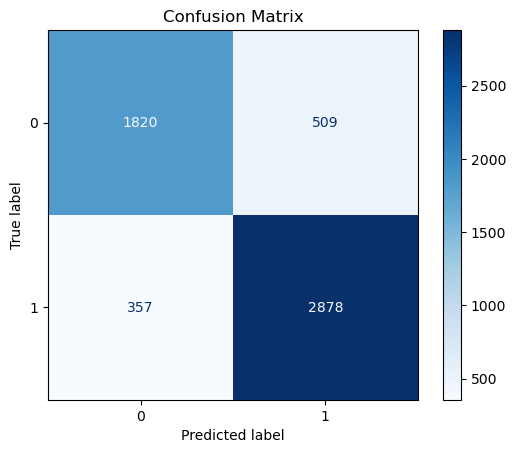

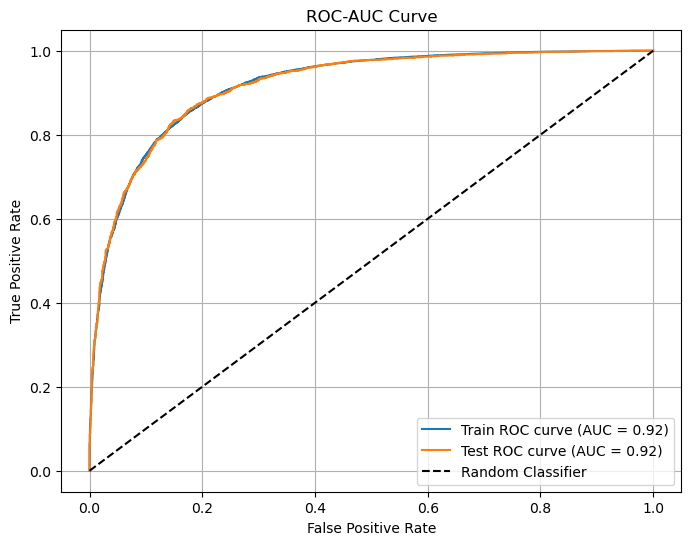


Model: KNN
Accuracy : 0.8258447160316319
Precision: 0.8340212264150944
Recall   : 0.8744976816074188
F1 Score : 0.8537799909461294


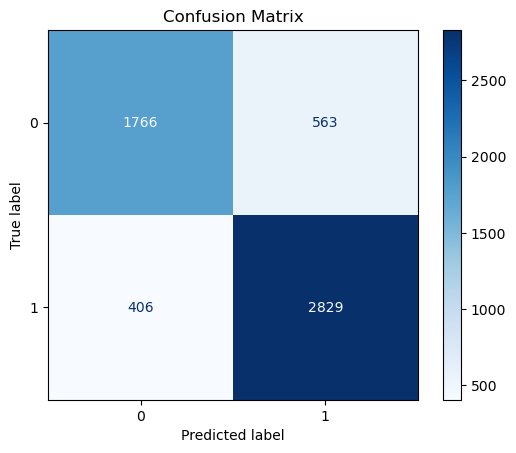

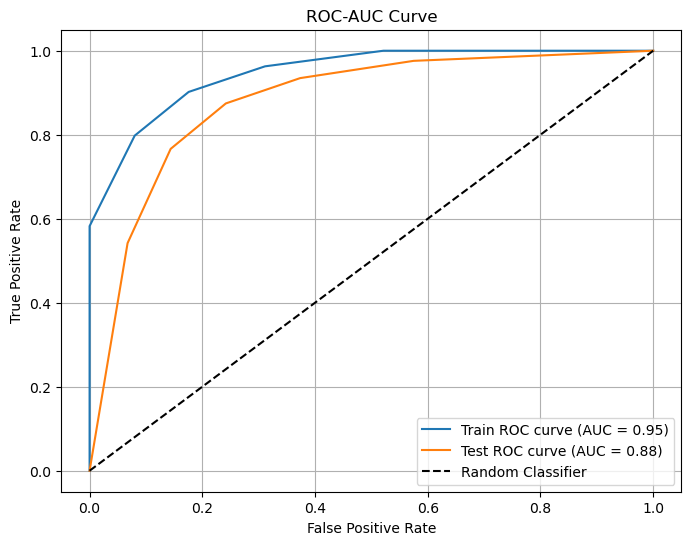


Model: Decision Tree
Accuracy : 0.7681524083393242
Precision: 0.8051459052400377
Recall   : 0.7931993817619784
F1 Score : 0.7991279975085643


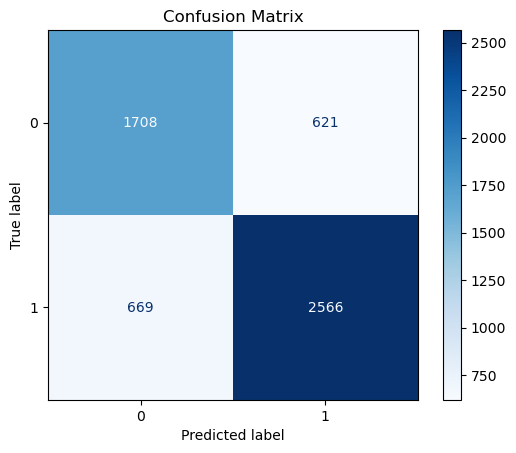

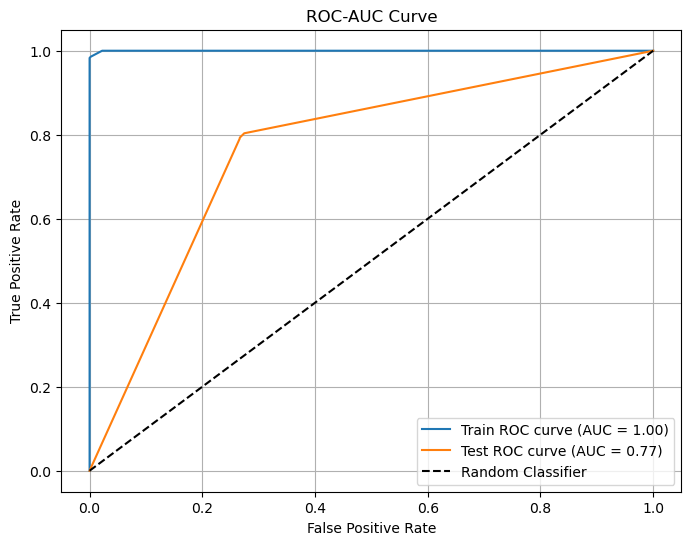


Model: Random Forest
Accuracy : 0.8253055355859095
Precision: 0.8403007518796992
Recall   : 0.863678516228748
F1 Score : 0.8518292682926829


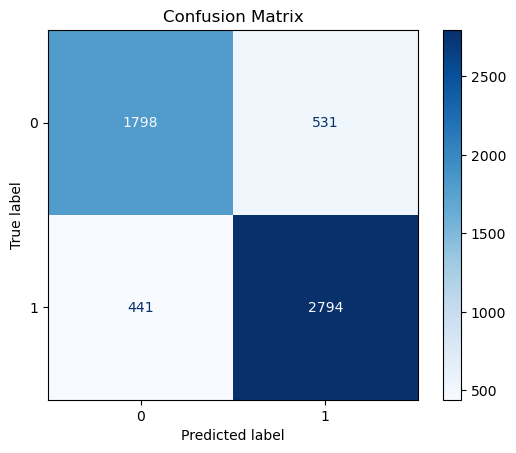

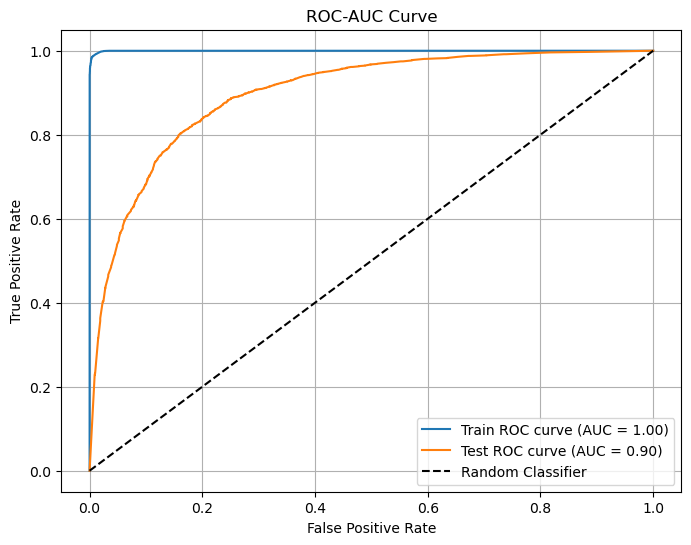


Model: Naive Bayes
Accuracy : 0.8308770668583753
Precision: 0.8566542288557214
Recall   : 0.8516228748068007
F1 Score : 0.8541311424585336


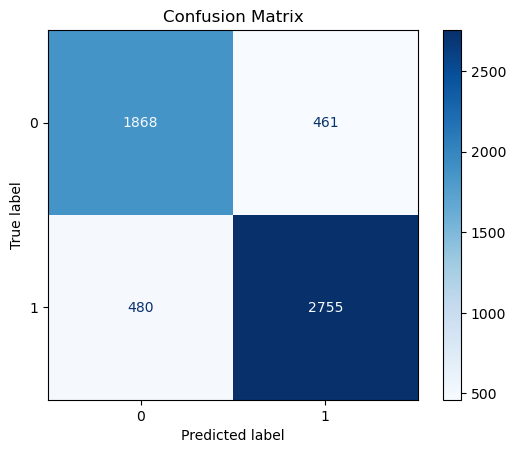

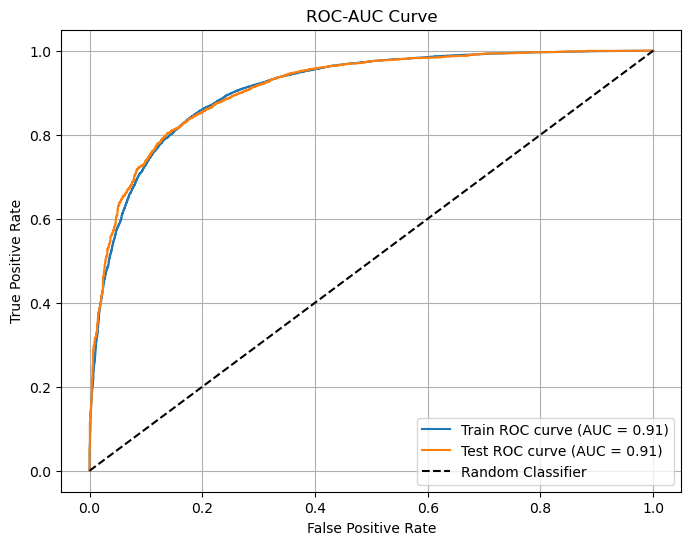


Model: Gradient Boosting Classifier
Accuracy : 0.8445363048166786
Precision: 0.8493514150943396
Recall   : 0.8905718701700155
F1 Score : 0.8694733665308586


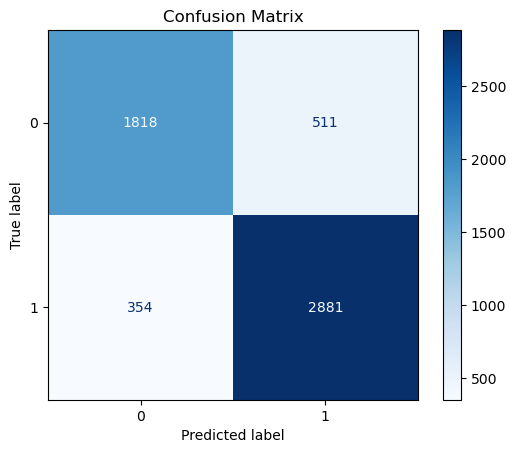

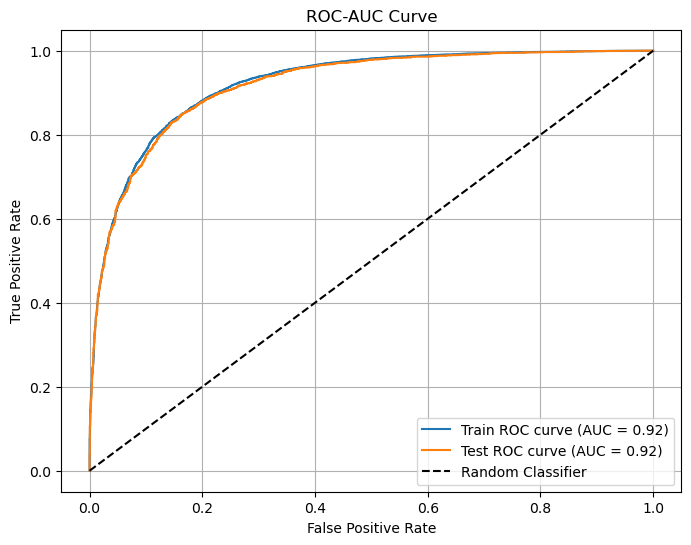

In [67]:
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "KNN": KNeighborsClassifier(),
    "Decision Tree": DecisionTreeClassifier(random_state=24),
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=24),
    "Naive Bayes": GaussianNB(),
    "Gradient Boosting Classifier": GradientBoostingClassifier()
}

for name, model in models.items():    
    model.fit(x_train, y_train)
    y_pred = model.predict(x_test)
    print(f"Model: {name}")
    print_classification_metrics(y_test, y_pred)
    plot_confusion_matrix(y_test, y_pred, model)
    plot_roc_auc(model, x_train, y_train, x_test, y_test)
    print()

KNN, Decision Tree and Random Forest has an overfitting problem as can be seen by the high confidence on train data and low confidence on test data.

On this parameter, Logistic Regression, Naive Bayes and Gradient Boosting Classifier show great generalization with very similar test and train scores.

Now comparing these 3 on the basis of other metrics:

In [68]:
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Naive Bayes": GaussianNB(),
    "Gradient Boosting Classifier": GradientBoostingClassifier()
}

for name, model in models.items():    
    model.fit(x_train, y_train)
    y_pred = model.predict(x_test)
    print(f"Model: {name}")
    print_classification_metrics(y_test, y_pred)
    print()

Model: Logistic Regression
Accuracy : 0.8443565780014378
Precision: 0.8497195157956894
Recall   : 0.889644513137558
F1 Score : 0.8692237994563576

Model: Naive Bayes
Accuracy : 0.8308770668583753
Precision: 0.8566542288557214
Recall   : 0.8516228748068007
F1 Score : 0.8541311424585336

Model: Gradient Boosting Classifier
Accuracy : 0.8445363048166786
Precision: 0.8493514150943396
Recall   : 0.8905718701700155
F1 Score : 0.8694733665308586



Out of these 3, Logistic Regression shows the best scores with Gradient Boosting a close runner up.
We will go ahead and fine tune the model using Logistic Regression as it also has a high Interpretability for stakeholders and its very fast compared to Gradient Boosting.

Let's apply Logistic Regression at each stage of the Machine Learning Lifecycle to see how our transformations affected the metrics.

In [69]:
datasets = [df_encoded, df_encoded_outliersHandled, df_encoded_outliersHandled_standardized, df_encoded_outliersHandled_featureEngineering, df]

Accuracy : 0.8500089814981139
Precision: 0.8485663082437276
Recall   : 0.8964973177658567
F1 Score : 0.871873561454657


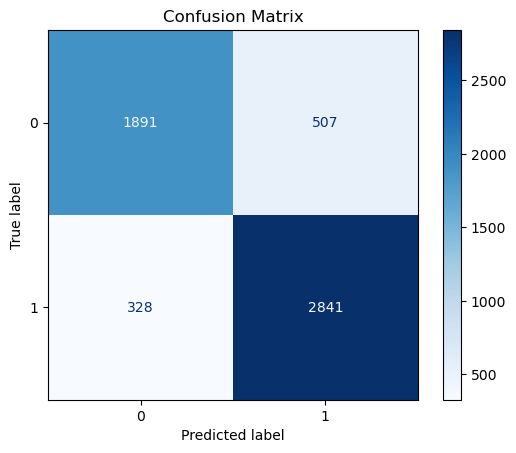

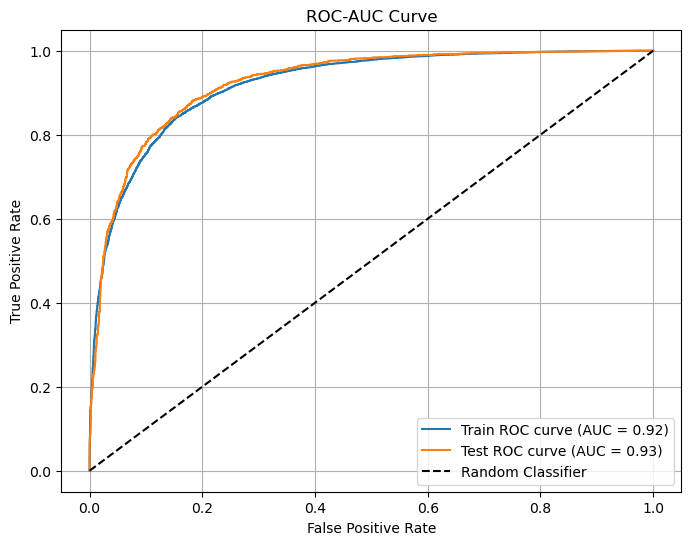


Accuracy : 0.8413012221423436
Precision: 0.851051051051051
Recall   : 0.8798509779571562
F1 Score : 0.8652114181041063


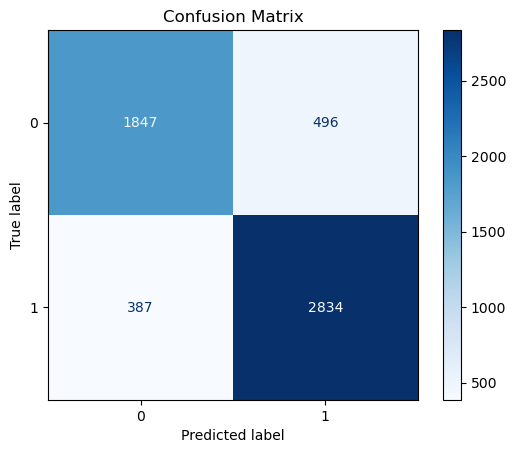

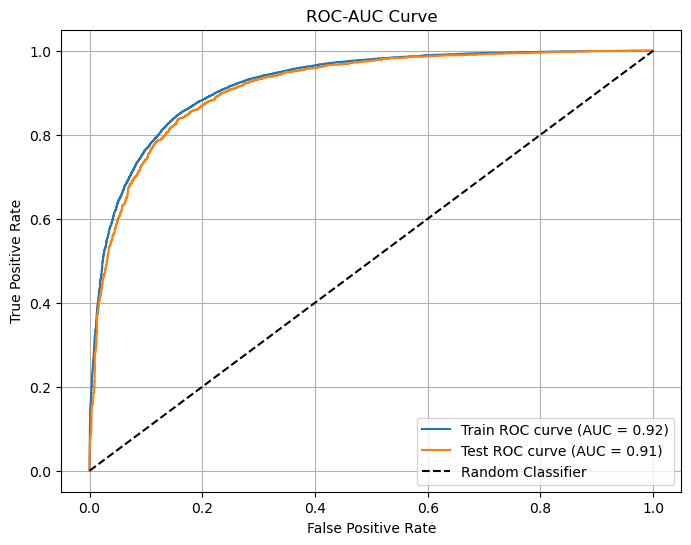


Accuracy : 0.8413012221423436
Precision: 0.851051051051051
Recall   : 0.8798509779571562
F1 Score : 0.8652114181041063


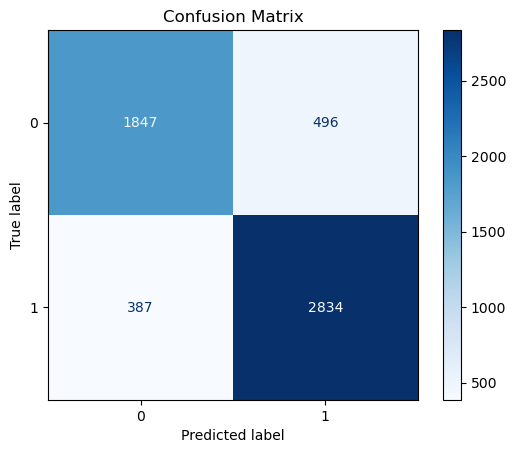

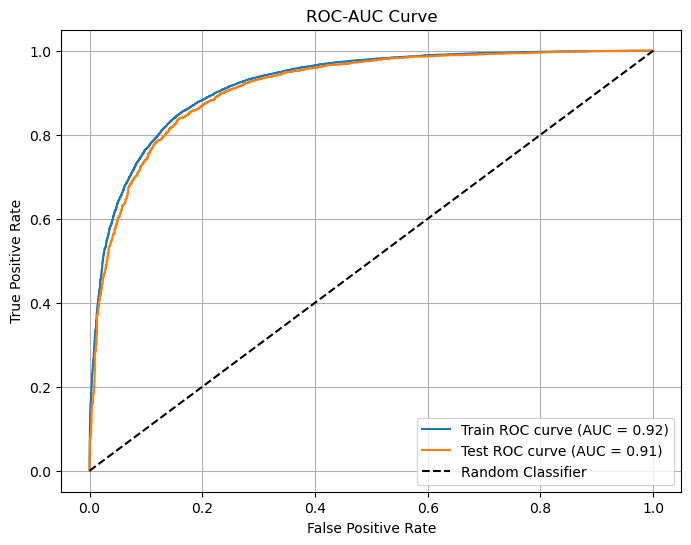


Accuracy : 0.840941768511862
Precision: 0.8509615384615384
Recall   : 0.8792300527786402
F1 Score : 0.8648648648648649


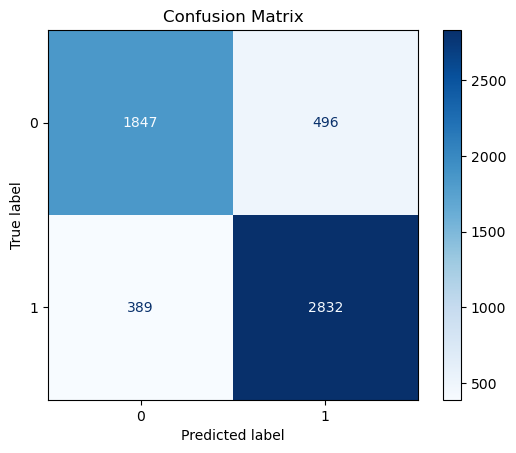

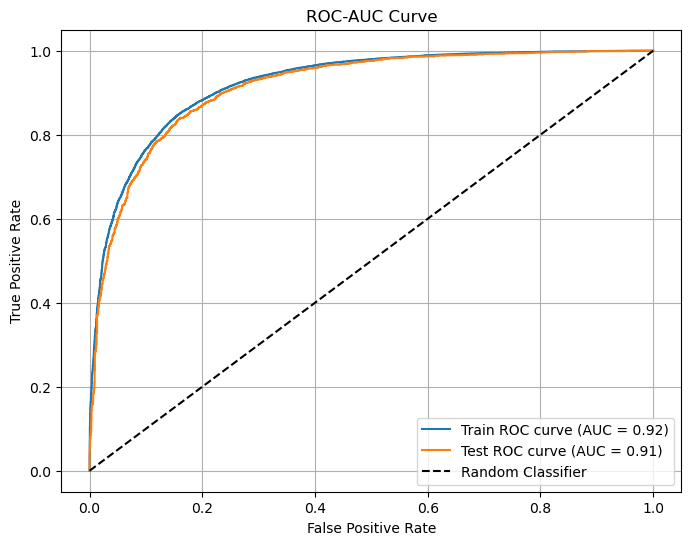


Accuracy : 0.8389647735442128
Precision: 0.8477415495064313
Recall   : 0.8798509779571562
F1 Score : 0.8634978671541743


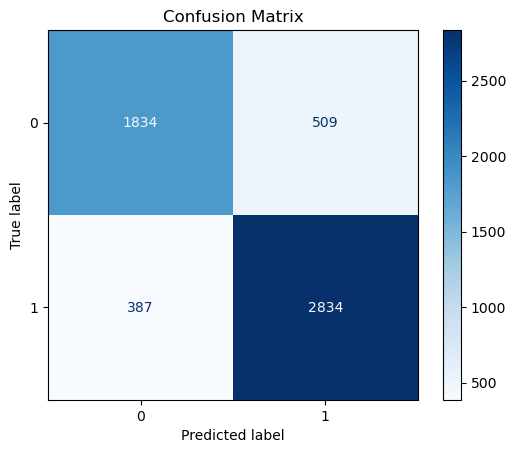

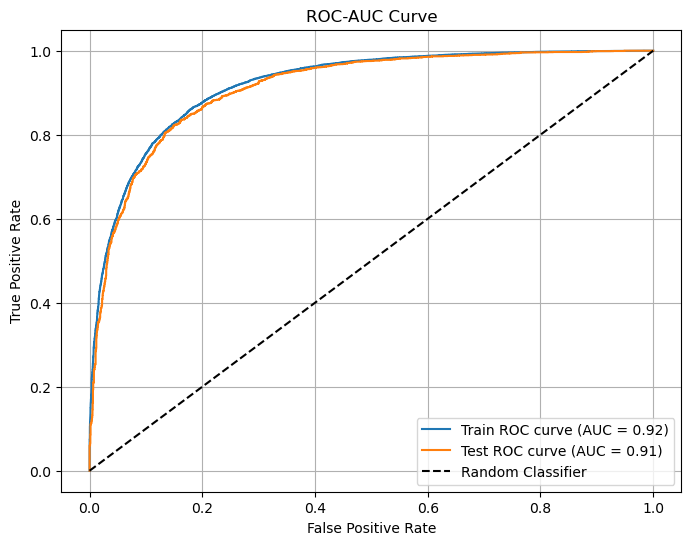

In [70]:
for dataset in datasets:
    x = dataset.drop(columns=['Depression'])
    y = dataset['Depression']
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=34)
    model = LogisticRegression(max_iter=1000)
    model.fit(x_train, y_train)
    y_pred = model.predict(x_test)
    print_classification_metrics(y_test, y_pred)
    plot_confusion_matrix(y_test, y_pred, model)
    plot_roc_auc(model, x_train, y_train, x_test, y_test)
    print()

Weirdly, the scores are more or less consistent at each stage after encoding. Our transformations did not help much except a slight increase in accuracy after performing Feature Engineering and slight dip in Test ROC after Feature Selection.

In [71]:
# Save model
joblib.dump(model, 'depression_model.pkl')

['depression_model.pkl']

In [72]:
df.head()

,Total_Stress,Academic Pressure,Financial Stress,Sleep Duration,Work Hours,Suicidal Thoughts,Age,Dietary Habits,Family History,Depression
0,0.0,1.0,-1.0,0.0,-0.833333,1,0.888889,0.5,0,1
1,-1.0,-0.5,-0.5,0.0,-0.833333,0,-0.111111,0.0,1,0
2,-1.0,0.0,-1.0,-0.5,0.166667,0,0.666667,0.5,1,0
3,1.0,0.0,1.0,0.5,-0.666667,1,0.333333,0.0,1,1
4,-0.5,0.5,-1.0,0.0,-1.166667,1,0.000000,0.0,0,0


In [73]:
df.columns

Index(['Total_Stress', 'Academic Pressure', 'Financial Stress',
       'Sleep Duration', 'Work Hours', 'Suicidal Thoughts', 'Age',
       'Dietary Habits', 'Family History', 'Depression'],
      dtype='object')

'Total Stress', 'Academic Pressure', 'Financial Stress', 'Sleep Duration', 'Work Hours',
                        'Suicidal Thoughts', 'Age', 'Dietary Habits', 'Family History'

# Deployment

Deployment in GUI